The network is based on 
Dhara, A and M.K. Sen, 2022, Physics-guided deep autoencoder to overcome the need
for a starting model in full-waveform inversion, The Leading Edge.

[https://doi.org/10.1190/tle41060375.1](https://doi.org/10.1190/tle41060375.1)

There have been some modifications to allow the network work with different acquisition geometry.

In [1]:
from utils import seed_everything
seed_everything(42)

from config import *
from networks import Autoencoder

/home/amardan/fwi/0_env38/lib/python3.8/site-packages/torch/utils/cpp_extension.py:295: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(
/home/amardan/fwi/0_env38/lib/python3.8/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, geta

In [2]:
!python ./d_obs_deepwave.py

/home/amardan/fwi/0_env38/lib/python3.8/site-packages/torch/utils/cpp_extension.py:295: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(
/home/amardan/fwi/0_env38/lib/python3.8/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, geta

In [3]:
print(f"Running on {DEVICE}")
d_obs = torch.load(
    f= PATH + "/data_model/taux_obs_" + PACKAGE + "_" + MODEL + "_" + str(N_SHOTS)
    )

# TODO:  Normalize 
# d_obs = data_normalization(d_obs)
d_obs = d_obs.unsqueeze(0).to(device=DEVICE)

vp, vp0 = earth_model(MODEL, smooth=15, 
                      device=DEVICE)

well_locations = int(vp.shape[1] //2)
depth = int(3 * vp.shape[0] // 4)
well_data = vp[:depth, well_locations]

Running on cuda


In [4]:
criteria = torch.nn.L1Loss(reduction='sum')

autoencoder = Autoencoder(
        batch_size=BATCH_SIZE, 
        in_channels=N_SHOTS,
        n_blocks_encoder=N_BLOCKS_ENCODER, 
        n_blocks_decoder=N_BLOCKS_DECODER,
        final_size_encoder=FINAL_SIZE_ENCODER, 
        initial_shape_decoder=DECODER_INITIAL_SHAPE,
        nt=NT, nr=N_RECEIVERS,
        final_spatial_shape=model_shape,
        m_min=VP_MIN, m_max=VP_MAX,
        final_out_channels=FINAL_OUT_CHANNEL
        )

autoencoder = autoencoder.to(device=DEVICE)

In [5]:
optim_autoencoder = torch.optim.Adam(autoencoder.parameters(), lr=1e-3, betas=(0.5, 0.9))
scheduler_autoencoder = torch.optim.lr_scheduler.StepLR(optim_autoencoder, LR_MILESTONE, gamma=0.5)
    
all_loss_data = []
all_loss_model = []
all_loss_prior = []
   

/home/amardan/fwi/0_env38/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


Iteration 1 ===== loss: 116830.61197916667 for data and 21749454.0 for model


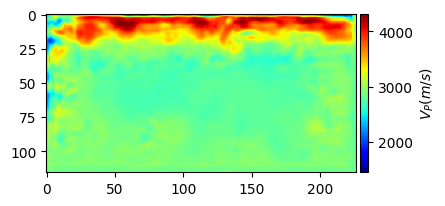

Iteration 31 ===== loss: 22063.40946451823 for data and 4129798.25 for model
Iteration 61 ===== loss: 18671.13651529948 for data and 3698438.75 for model


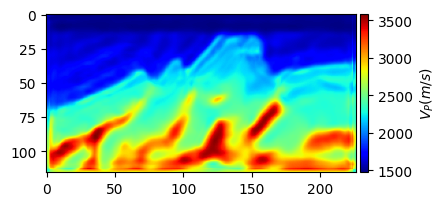

Iteration 91 ===== loss: 16441.189331054688 for data and 3451551.0 for model
Iteration 121 ===== loss: 12070.591857910156 for data and 3193262.25 for model


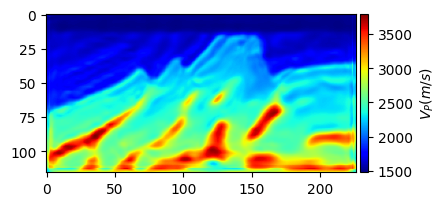

Iteration 151 ===== loss: 11555.723775227865 for data and 3119114.5 for model
Iteration 181 ===== loss: 10632.700764973959 for data and 3064165.25 for model


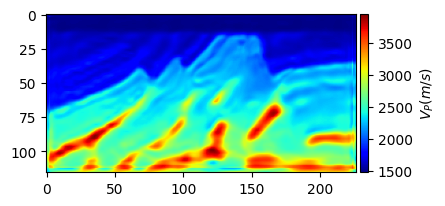

Iteration 211 ===== loss: 10541.406616210938 for data and 3023264.0 for model
Iteration 241 ===== loss: 8490.123453776041 for data and 2961196.0 for model


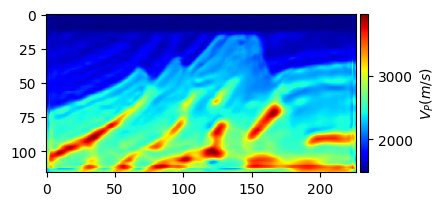

Iteration 271 ===== loss: 8337.315592447918 for data and 2932287.5 for model


In [6]:
for iter in range(ITERATION):
    loss_data, loss_prior, m, autoencoder  = train_fun(
        Physics=Physics, 
        autoencoder=autoencoder,
        d_obs=d_obs, 
        freqs=INV_FREQS,
        optim_autoencoder=optim_autoencoder, 
        criteria=criteria,
        mini_batches = MINI_BATCHES,
        src_loc=src_loc, 
        rec_loc=rec_loc, 
        src=src,
        inpa=inpa, 
        lam_prior=LAM_PRIOR,
        well_locations=well_locations,
        well_data=well_data,
        test=None)
    
    all_loss_data.append(loss_data)
    all_loss_prior.append(loss_prior) 
    
    with torch.no_grad():
        all_loss_model.append(
            criteria(m, vp).item()
        )
    if iter%PRINT_FREQ == 0:
        print(f"Iteration {iter + 1} ===== loss: {all_loss_data[-1]} for data and {all_loss_model[-1]} for model")
    if iter%SAVE_FREQ == 0:
        fig, ax = plt.subplots(1,1, figsize=(4, 4))
        im = ax.imshow(m.detach().cpu(), 
                          cmap="jet", vmin=m.min(), 
                   vmax=m.max()) 
        points = ax.get_position().get_points()
        dy = points[1, 1] - points[0, 1]

        cax = fig.add_axes([0.91, points[0, 1], 0.02, dy])
        cax.yaxis.set_ticks_position("right")
        cbar = fig.colorbar(im, cax=cax, orientation="vertical", 
                            extend="neither", label="$V_P (m/s)$"
                            )
        plt.show()
            
    scheduler_autoencoder.step()


In [7]:
vp.cpu().shape

torch.Size([116, 227])

In [8]:
well_locations

113

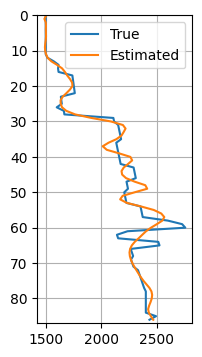

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(2,4))

ax.plot(vp.cpu()[:depth, well_locations], 
            np.arange(depth), 
            label="True")
ax.plot(m.cpu().detach()[:depth, well_locations], 
            np.arange(depth), 
            label="Estimated")
ax.set_ylim(0, depth)
ax.invert_yaxis()
ax.grid()
ax.legend()


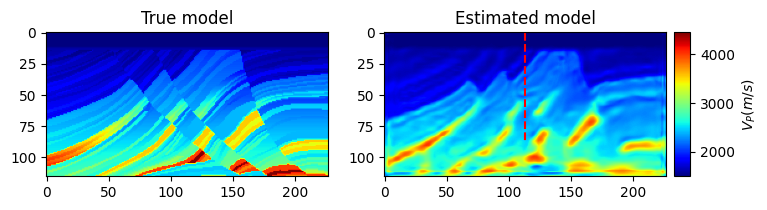

In [10]:
vp = vp.cpu()
vp_min = vp.min()
vp_max = vp.max()

estimated = autoencoder(d_obs)[0,0, ...]
estimated = estimated.cpu().detach()

fig, ax = plt.subplots(1,2, figsize=(8, 4))
im = ax[0].imshow(vp, cmap="jet", vmin=vp_min, 
                   vmax=vp_max)

ax[0].set_title("True model")

# ax.invert_yaxis()
im = ax[1].imshow(estimated, cmap="jet", vmin=vp_min, 
                   vmax=vp_max) 
ax[1].set_title("Estimated model")
ax[1].plot([well_locations, well_locations], 
         [0, depth], 'r', linestyle="--") 
points = ax[1].get_position().get_points()
dy = points[1, 1] - points[0, 1]

cax = fig.add_axes([0.91, points[0, 1], 0.02, dy])
cax.yaxis.set_ticks_position("right")
cbar = fig.colorbar(im, cax=cax, orientation="vertical", 
                    extend="neither", label="$V_P (m/s)$"
                    )


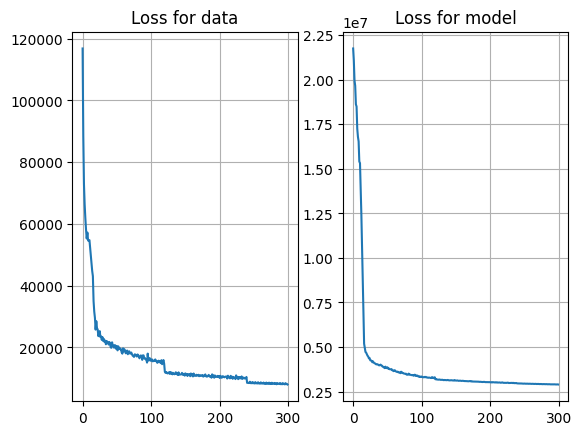

In [11]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(all_loss_data, 
            label="Data")
ax[0].set_title("Loss for data")

ax[1].plot(all_loss_model, 
            label="Model")
ax[1].set_title("Loss for model")

ax[0].grid()
ax[1].grid()

In [12]:
# file_name = PATH + "/results/"+ PACKAGE + "_autoencoder_ns60_freqs_152560.pth.tar"
# save_checkpoint(autoencoder, file_name)

In [13]:
# from PyFWI.seismic_io import save_mat
# save_mat(PATH + "/results/"+ PACKAGE, data={"m":m, "res":all_loss}, unique=True)